<a href="https://colab.research.google.com/github/Abonvicine/ESTUDOS---Gerais/blob/main/MERGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Inserir data do arquivo
from datetime import datetime
DataStr = '2021-11-17' #@param {type:"date"}
Data = datetime.strptime(DataStr, '%Y-%m-%d')

# Dependencias iniciais

In [2]:
!python -V

Python 3.7.12


In [3]:
!pip install numpy==1.20.1

In [4]:
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install -q pyproj==1.9.6

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
     - 133.1 MB 1.3 MB/s
     |████████████████████████████████| 6.3 MB 5.5 MB/s 
     |████████████████████████████████| 219 kB 58.4 MB/s 
     |████████████████████████████████| 2.8 MB 5.4 MB/s 


In [5]:
!pip install --upgrade pygrib
!pip install geojsoncontour
!pip install cmocean

     |████████████████████████████████| 16.5 MB 86 kB/s 
     |████████████████████████████████| 223 kB 5.4 MB/s 


In [6]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import urllib.request as req
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import geojsoncontour
import cmocean
import pygrib
import shapely as shp
import numpy as np
import pandas as pd
import os

# Importando dados

In [8]:
dia = str(Data.day).zfill(2)
mes = str(Data.month).zfill(2)
ano = str(Data.year)

if not(os.path.isdir("/content/MERGE")):
    os.mkdir("/content/MERGE")

arquivos = [
            f"MERGE_CPTEC_{ano}{mes}{dia}.ctl",
            f"MERGE_CPTEC_{ano}{mes}{dia}.grib2",
            f"MERGE_CPTEC_{ano}{mes}{dia}.idx"
            ]

for i in arquivos:
    url = f'http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2021/{mes}/{i}'
    req.urlretrieve(url, f'/content/MERGE/{i}')

gr = pygrib.open(f"/content/MERGE/{arquivos[1]}")  

# Extraindo Dados do Arquivo .GRIB2

## Arquivo GRIB2

In [9]:
grb = gr.select(name='Precipitation')[0]
lat1 = -35
lat2 =   7
lon1 = 283
lon2 = 328
data, lats, lons = grb.data(lat1=lat1,lat2=lat2,lon1=lon1,lon2=lon2)
print(grb)

1:Precipitation:kg m**-2 (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 202111171200


In [10]:
dataList = []

flatten_lons = lons.flatten()
flatten_lats = lats.flatten()
flatten_data = data.flatten()

for i in range(flatten_data.shape[0]):

    lat = round(flatten_lats[i],2)
    lon = round(flatten_lons[i],2)

    lon = round(((lon + 180) % 360) - 180,2) #transforma longitude de 0/360 para -180/180

    precipitation = round(flatten_data[i],2)

    dataList.append([lat,lon,precipitation])

## Plotando MAPA

In [13]:
def make_map(height, width):
    plt.figure(figsize=(height,width))
    m = Basemap(projection='merc',llcrnrlat=lat1, urcrnrlat=lat2, llcrnrlon=lon1, urcrnrlon=lon2, resolution='i')

    m.drawcoastlines(linewidth=2.0)
    m.drawcountries(linewidth=2.0)
    m.drawstates(color="#32353b")
    m.drawrivers(color="#a3afc2")

    
    return m



/usr/local/lib/python3.7/dist-packages/geojsoncontour/utilities/multipoly.py:33: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)


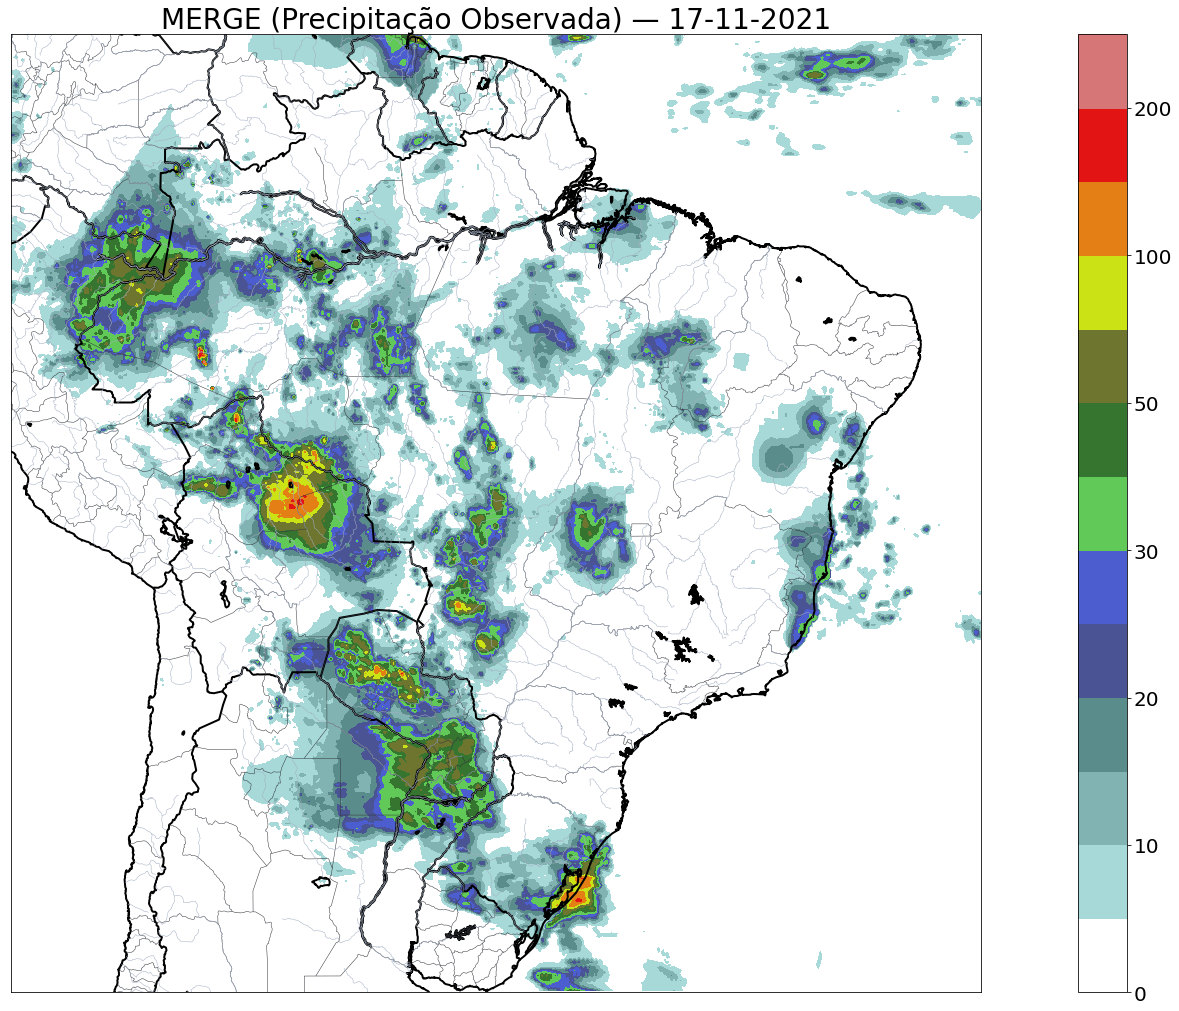

In [14]:
# Função Basemap, plotar a projeção, o recorte das latitude e longitude e definir a resolução da imagem.
m = make_map(20,30)

#Inserindo os lat e lon a figura criada pelo Basemap e vinculando às variavéis  x e y.
x, y = m(lons, lats)

#Função do Basemap para realizar a interpolação e criação de polígonos

#colorSchema = cmocean.cm.dense
colors = ["#ffffff","#a7d9d8","#81b3b2","#5a8c8b","#4a5494","#4c5ecf","#60c957","#35752f","#6d752f","#cbe314","#e37f14","#e31414","#d67676","#4d2757"]
contourf = m.contourf(x, y, data.data, levels = [0,5,10,15,20,25,30,40,50,75,100,150,200,250], colors=colors)
cbar = m.colorbar(location='right', pad="10%")

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
     
#Inserir titulo a imagem 
plt.title(f"MERGE (Precipitação Observada) — {dia}-{mes}-{ano}",fontsize= 28)

#Convertendo para o formato Geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=3,
    stroke_width=3,
)

#Plotar imagem

plt.show()

## Interpolando o Arquivo 

In [ ]:
def mergeCoord(lat,lon):
    return f"{str(lat)}:{str(lon)}"

In [ ]:
previsao = pd.DataFrame(dataList,columns=['LAT','LNG',"PRECIPITAÇÃO"])
previsao["COORD"] = previsao.apply(lambda x: mergeCoord(x.LAT,x.LNG), axis =1 )
previsao = previsao[["COORD","PRECIPITAÇÃO"]]

fileName = f'/content/drive/MyDrive/CPFL/ARQUIVOS ONS/PRECIPITAÇÃO/Contornos/25042021_MERGE_interpolado.csv'
pontos_de_grade = pd.read_csv(fileName)
pontos_de_grade["COORD"] = pontos_de_grade.apply(lambda x: mergeCoord(x.LAT,x.LNG), axis =1 )
pontos_de_grade = pontos_de_grade[["COORD","ARQUIVO","BACIA"]]

df = pd.merge(pontos_de_grade, previsao, on='COORD', how="inner")

In [ ]:
reservatorios = df["ARQUIVO"].unique()

pMEDIA_res = {"RESERVATORIO":[],"PRECIPITAÇÃO":[]}
for res in reservatorios:
    filtro = df[df["ARQUIVO"] == res]
    media = filtro.mean()["PRECIPITAÇÃO"]
    pMEDIA_res["RESERVATORIO"].append(res.replace(".bln",''))
    pMEDIA_res["PRECIPITAÇÃO"].append(media)

In [ ]:
bacias = df["BACIA"].unique()

pMEDIA_bac = {"RESERVATORIO":[],"PRECIPITAÇÃO":[]}
for bac in bacias:
    filtro = df[df["BACIA"] == bac]
    media = filtro.mean()["PRECIPITAÇÃO"]
    pMEDIA_bac["RESERVATORIO"].append(bac)
    pMEDIA_bac["PRECIPITAÇÃO"].append(media)

In [ ]:
pMEDIA_RES = pd.DataFrame.from_dict(pMEDIA_res)
pMEDIA_RES.to_excel("MERGE_PMEDIA_res.xlsx")
pMEDIA_BAC = pd.DataFrame.from_dict(pMEDIA_bac)
pMEDIA_BAC.to_excel("MERGE_PMEDIA_bac.xlsx")